# EPS 109 Final Project: Altruism in Prey/Predator Relationships

Author: Isaac Merritt

## Altriusm

*Altruism* in this project will be defined as **a trait exhibited by individuals of a prey species who value the lives of their peers and the livelihood of their species more than their own individual life**. In the face of a life-threatening predator, altruistic individuals will attempt to save others rather than just themselves.

Main question this project will try to answer: **How does altruism affect a prey species as a whole?**

To answer this question, this project will study the relationships between three different prey/predator combinations:
- One with no altruistic individuals
    - *Purely Selfish*
- One with half the prey population being altruistic individuals who put their lives in danger to save any other individuals of their species
    - *Hybrid Altruism*
- One with nearly the entire prey population being altruistic
    - *Altruism Dominant*

## Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FFMpegWriter

## Knobs

These are the adjustable knobs of the simulation, they can be tweaked to change the behavior of the model.

In [2]:
#Values of prey, altruistic prey, and predators in the data matrix DO NOT EDIT THIS LINE
prey = 1
altruistic_prey = .5
predator = -1

# Initial ratio of predators 
predator_ratio = .04

# Size of the environment
Xsize = 50
Ysize = 50

# Moves and Location Conversions DO NOT EDIT THESE 2 LINES
move_choices = np.array([-1, 0, 1])
conversion_dict = {0: (-1, -1), 1: (0, -1), 2: (1, -1), 3: (-1, 0), 4: (1, 0), 5: (-1, 1), 6: (0, 1), 7: (1, 1)}

# Probability of altruistic prey surviving their sacrifice
altruistic_survival_prob = .1

# Probability that a surviving prey individual reproduces asexually in the next timestep
reproduction_prob = .09

# Amount of moves to check before a prey decides to stay where it is
move_density_threshold = 5

## Functions

In [3]:
# Transitioning states happens in 3 steps:
# - Letting prey move
# - Letting prey hunt and move
# - Letting remaining prey reproduce
def transition(env):
    new_env = np.copy(env)
    
    # First pass for prey movement stage
    for x in np.arange(Xsize):
        for y in np.arange(Ysize):
            curr_individual = env[x, y]
            if curr_individual == prey or curr_individual == altruistic_prey:
                new_env = move_individual(new_env, x, y)
                
    env = np.copy(new_env)
    
    # Second pass for predator hunting stage
    for x in np.arange(Xsize):
        for y in np.arange(Ysize):
            curr_individual = env[x, y]
            if curr_individual == predator:
                
                # Execute hunting routine
                neighborhood = neighbors(env, x, y)
                candidates, = np.where((neighborhood == prey) | (neighborhood == altruistic_prey))
                
                # If an altruistic individual is there to help
                if altruistic_prey in candidates:
                    # If the altruistic individual dies saving everyone
                    if np.random.random() >= altruistic_survival_prob:
                        altruistic_prey_location = np.random.choice(np.where(neighborhood == altruistic_prey))
                        dx, dy = conversion_dict[altruistic_prey_location]
                        new_env[x+dx, y+dy] = 0

                # If there are no altruistic individuals present
                else:
                    if candidates.size < 2:
                        tributes = np.copy(candidates)
                    else:
                        tributes = np.random.choice(candidates, 2, replace=False)
                    # Kill 2 prey individuals at random
                    for tribute in tributes:
                        dx, dy = conversion_dict[tribute]
                        new_env[x+dx, y+dy] = 0
                
                # Move predator
                new_env = move_individual(new_env, x, y)
                
    env = np.copy(new_env)
                
    # Third pass for prey reproduction
    for x in np.arange(Xsize):
        for y in np.arange(Ysize):
            curr_individual = env[x, y]
            if curr_individual == prey or curr_individual == altruistic_prey:
                new_env = move_individual(new_env, x, y, reproduce=True)
                
    return new_env

# Look for a valid place to move/reproduce,
# don't move/reproduce if the region is too dense
def move_individual(new_env, x, y, reproduce=False):
    count = 0
    while count < move_density_threshold:
        dx = np.random.choice(move_choices)
        dy = np.random.choice(move_choices)
        if 0 <= x+dx < Xsize and 0 <= y+dy < Ysize and new_env[x+dx, y+dy] == 0:
            # Individual reproduces
            if reproduce:
                if np.random.random() <= reproduction_prob:
                    new_env[x+dx, y+dy] = new_env[x, y]
            # Individual moves
            else:
                new_env[x+dx, y+dy] = new_env[x, y]
                new_env[x, y] = 0
            break
        count += 1
    return new_env

# Helper function that gets the neighbors of a predator at a given timestep
# -1 if out of bounds, value of `env` otherwise
# Format:
# 0 3 5
# 1 - 6
# 2 4 7
def neighbors(env, x, y):
    result = []
    
    # Get neighbors to the left
    if y >= 1:
        if x == 0:
            result.append(-1)
            result.extend(env[x:x+2, y-1])
        elif x == env.shape[1]-1:
            result.extend(env[x-1:x+1, y-1])
            result.append(-1)
        else:
            result.extend(env[x-1:x+2, y-1])
    else:
        result.extend([-1] * 3)
            
    # Get above neighbor
    if x != 0:
        result.append(env[x-1, y])
    else:
        result.append(-1)
    
    # Get below neighbor
    if x != env.shape[1]-1:
        result.append(env[x+1, y])
    else:
        result.append(-1)
    
    # Get neighbors to the right
    if y < env.shape[0]-1:
        if x == 0:
            result.append(-1)
            result.extend(env[x:x+2, y+1])
        elif x == env.shape[1]-1:
            result.extend(env[x-1:x+1, y+1])
            result.append(-1)
        else:
            result.extend(env[x-1:x+2, y+1])
    else:
        result.extend([-1] * 3)
        
    return np.array(result)

In [4]:
# Populate the environment with n randomly placed individuals (indicated by marker argument) 
def populate(env, n, marker):
    population = 0
    while population < n:
        x = np.random.randint(Xsize)
        y = np.random.randint(Ysize)
        if env[x, y] == 0:
            env[x, y] = marker
            population += 1
    return env

## Animation Functions

In [5]:
def grab_env_frame(XS, YS, env, t, sim_type, individual_data, writer, fig, ax1, ax2):
    
    altruism = individual_data.shape[0] == 3
    
    # Stacked Bar Plot
    
    labels = np.arange(t+1)
    prey_data = individual_data[0]
    if altruism:
        altruistic_prey_data = individual_data[2]
    predator_data = individual_data[1]

    cmap = cm.get_cmap('bwr_r')
    ax1.bar(labels, prey_data, label='prey', color=cmap(256*prey))
    if altruism:
        ax1.bar(labels, altruistic_prey_data, bottom=prey_data, label='altruistic prey', color=cmap(int(128*(1+altruistic_prey))))
        ax1.bar(labels, predator_data, bottom=altruistic_prey_data+prey_data, label='predators', color=cmap(0))
    else:
        ax1.bar(labels, predator_data, bottom=prey_data, label='predators', color=cmap(0))
    ax1.legend()
    ax1.set_xlabel("Days", labelpad=-5)
    
    # Scatterplot
    ax2.scatter(XS, YS, c=env[XS, YS], cmap='bwr_r')
    
    # Title for the whole figure
    fig.suptitle(f"{sim_type.capitalize()} Prey/Predator Simulation", fontsize=16, y=.92)
    
    # TODO plt.title(f"Prey vs. Predator ({'' if altruism else 'no'} Altruism present)")
    plt.pause(0.01)
    writer.grab_frame()
    ax1.clear()
    ax2.clear()

In [6]:
def simulation(timesteps, sim_type):
    
    assert sim_type in ['standard', 'hybrid', 'altruistic'], "Invalid Simulation Type"
    
    altruism = sim_type != 'standard'
    
    # Initialize simulation starting state
    X = np.arange(Xsize)
    Y = np.arange(Ysize)
    
    XS, YS = np.meshgrid(X, Y)
    
    ENV = np.zeros((Xsize, Ysize))
    ENV_size = Xsize * Ysize
    
    ENV = populate(ENV, int(ENV_size*prey_ratio), prey)
    prey_data = np.zeros(timesteps+1)
    prey_data[0] = int(ENV_size*prey_ratio)

    if altruism:
        ENV = populate(ENV, int(ENV_size*altruistic_prey_ratio), altruistic_prey)
        altruistic_prey_data = np.zeros(timesteps+1)
        altruistic_prey_data[0] = int(ENV_size*altruistic_prey_ratio)
    
    ENV = populate(ENV, int(ENV_size*predator_ratio), predator)
    predator_data = np.zeros(timesteps+1)
    predator_data[0] = int(ENV_size*predator_ratio)
        
    if altruism:
        individual_data = np.array([prey_data, predator_data, altruistic_prey_data])
    else:
        individual_data = np.array([prey_data, predator_data])
    
    # Animation metadata
    metadata = dict(title="Animation for Final Project", artist="Isaac Merritt",comment=f"{timesteps} days")
    writer = FFMpegWriter(fps=5, metadata=metadata, bitrate=200000)
    
    # Figure setup
    fig, axs = plt.subplots(4)
    fig.set_size_inches(9, 12)
    ax1 = axs[0]
    gs = axs[1].get_gridspec()
    for ax in axs[1:]:
        ax.remove()
    ax2 = fig.add_subplot(gs[1:, -1])
    
    # Begin simulation
    filename = f"{sim_type}_simulations/simulation{timesteps}days.mp4"
    with writer.saving(fig, filename, dpi=200):
        
        # Grab the starting state frame
        grab_env_frame(XS, YS, ENV, timesteps, sim_type, individual_data, writer, fig, ax1, ax2)
        
        # Begin transitioning for `timesteps` timesteps
        for t in np.arange(timesteps):
            ENV = transition(ENV)
            individual_data[0, t+1] = np.count_nonzero(ENV == prey)
            individual_data[1, t+1] = np.count_nonzero(ENV == predator)
            if altruism:
                individual_data[2, t+1] = np.count_nonzero(ENV == altruistic_prey)
            grab_env_frame(XS, YS, ENV, timesteps, sim_type, individual_data, writer, fig, ax1, ax2)

## Selfish Simumation

All prey individuals will not be altruistic, and do not value others lives over their own.

In [7]:
# Initial ratios of prey, altruistic prey, and predators in a selfish simulation
prey_ratio = .25
altruistic_prey_ratio = 0

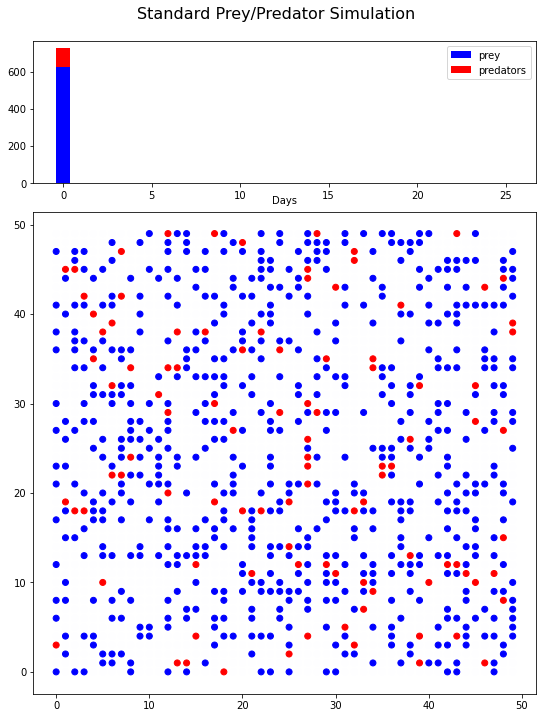

In [8]:
simulation(25, 'standard')

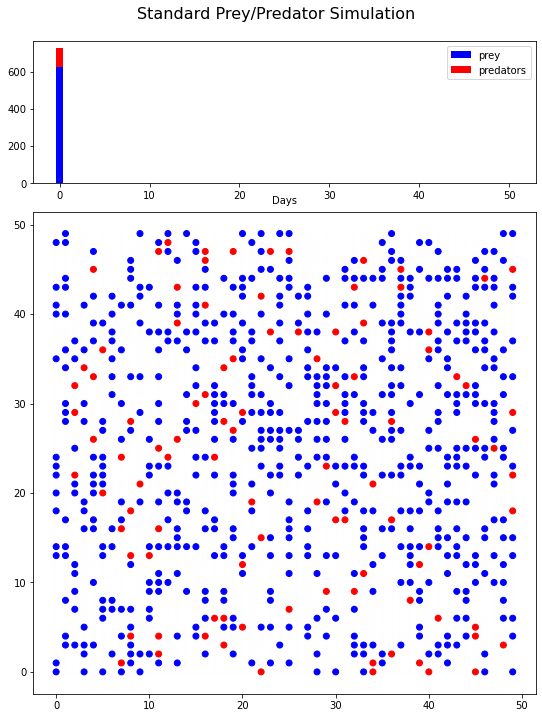

In [9]:
simulation(50, 'standard')

## Hybrid Simulation

Half the prey individuals in this simulation will value others' lives above their own.

In [16]:
# Initial ratios of prey, altruistic prey, and predators in a hybrid simulation
prey_ratio = .1875
altruistic_prey_ratio = .0625

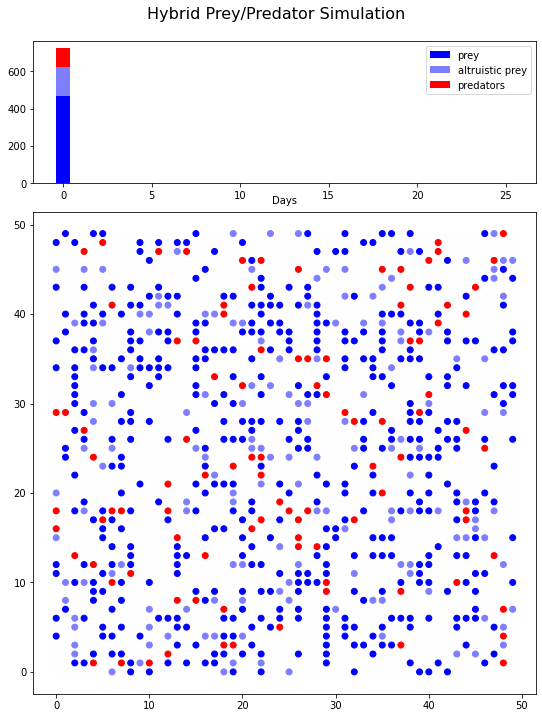

In [17]:
simulation(25, 'hybrid')

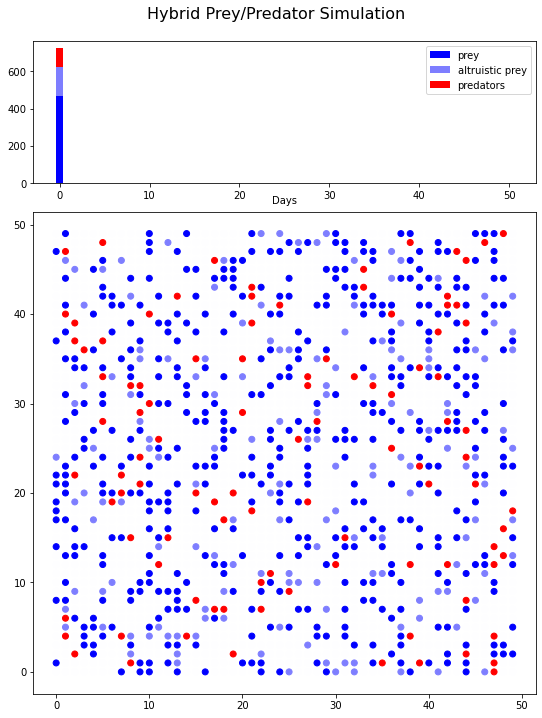

In [18]:
simulation(50, 'hybrid')

## Altruistic Dominant Simulation

Most prey individuals will value others' lives above their own

In [13]:
# Initial ratios of prey, altruistic prey, and predators in a altruistic dominant simulation
prey_ratio = .0625
altruistic_prey_ratio = .1875

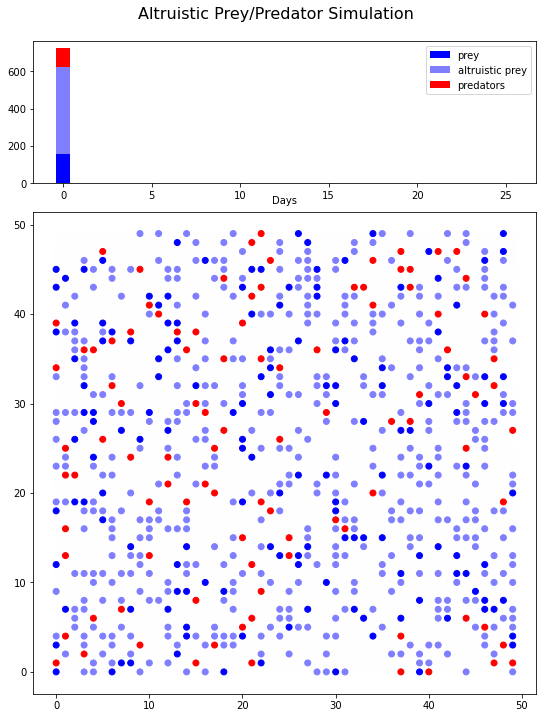

In [14]:
simulation(25, 'altruistic')

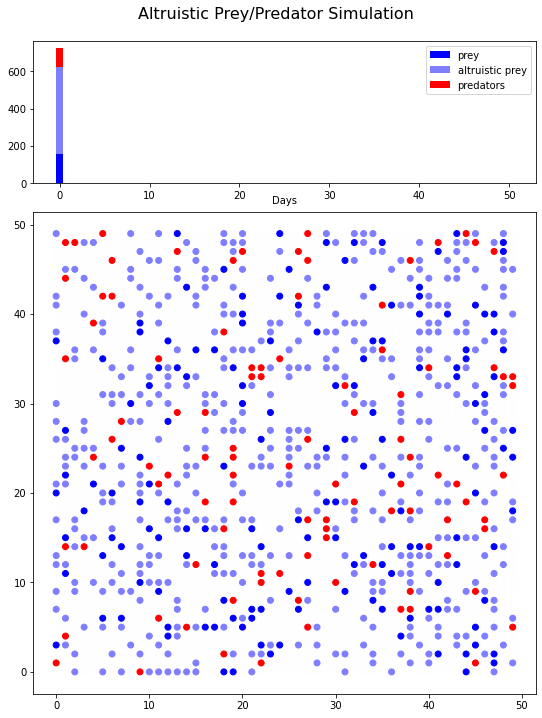

In [15]:
simulation(50, 'altruistic')

## Conclusions

As is evident by animations of the above simulations, the presence of enough altruistic individuals tends to result in a situation where selfish prey are protected by walls of altruistic prey against the predators. This allows potentially dwindiling numbers of the prey to replenish more reliably because the altruists allow the selfish prey to reproduce in peace.

This behavior of the simulation that rewards the species for its altruism, but actually punishes the indivudual is what makes altruism so interesting. Though altruism is beneficial to the group, it is detrimental to the individual, making it difficult to find natural 'volunteers' to protect the species from danger.